  
#### line_Ps is a principal version of 1st-level 1D algorithm

    Operations:
- Cross-compare consecutive pixels within each row of image, forming dert_: queue of derts, each a tuple of derivatives per pixel.
dert_ is then segmented into patterns Pms and Pds: contiguous sequences of pixels forming same-sign match or difference.
Initial match is inverse deviation of variation: m = ave_|d| - |d|,
rather than a minimum for directly defined match: albedo of an object doesn't correlate with its predictive value.

- Match patterns Pms are spans of inputs forming same-sign match. Positive Pms contain high-match pixels, which are likely
  to match more distant pixels. Thus, positive Pms are evaluated for cross-comp of pixels over incremented range.

- Difference patterns Pds are spans of inputs forming same-sign ds. d sign match is a precondition for d match, so only
  same-sign spans (Pds) are evaluated for cross-comp of constituent differences, which forms higher derivatives.
  (d match = min: rng+ comp value: predictive value of difference is proportional to its magnitude, although inversely so)

Both extended cross-comp forks are recursive: resulting sub-patterns are evaluated for deeper cross-comp, same as top patterns.
These forks here are exclusive per P to avoid redundancy, but they do overlap in line_patterns_olp.

In [36]:

# add ColAlg folder to system path
import sys
from os.path import dirname, join, abspath

from numpy import int16, int32
sys.path.insert(0, abspath(join(dirname("CogAlg"), '..')))
import cv2
# import argparse
import pickle
from time import time
from matplotlib import pyplot as plt
from itertools import zip_longest
from frame_2D_alg.class_cluster import ClusterStructure, NoneType, comp_param
import numpy as np

In [37]:
class Cdert(ClusterStructure):
    i = int  # input for range_comp only
    p = int  # accumulated in rng
    d = int  # accumulated in rng
    m = int  # distinct in deriv_comp only
    mrdn = lambda: 1.0  # -> Rdn: rdn counter per P

In [38]:
class CP(ClusterStructure):
    L = int
    I = int
    D = int
    M = int  # summed ave - abs(d), different from D
    Rdn = lambda: 1.0  # mrdn counter
    x0 = int
    dert_ = list  # contains (i, p, d, m, mrdn)
    subset = list  # 1st sublayer' rdn, rng, xsub_pmdertt_, _xsub_pddertt_, sub_Ppm_, sub_Ppd_
    # for layer-parallel access and comp, ~ frequency domain, composition: 1st: dert_, 2nd: sub_P_[ dert_], 3rd: sublayers[ sub_P_[ dert_]]:
    sublayers = list  # multiple layers of sub_P_s from d segmentation or extended comp, nested to depth = sub_[n]
    subDertt_ = list  # m,d' [L,I,D,M] per sublayer, conditionally summed in line_PPs
    derDertt_ = list  # for subDertt_s compared in line_PPs

In [39]:
verbose = False
# pattern filters or hyper-parameters: eventually from higher-level feedback, initialized here as constants:
ave = 15  # |difference| between pixels that coincides with average value of Pm
ave_min = 2  # for m defined as min |d|: smaller?
ave_M = 20  # min M for initial incremental-range comparison(t_), higher cost than der_comp?
ave_D = 5  # min |D| for initial incremental-derivation comparison(d_)
ave_nP = 5  # average number of sub_Ps in P, to estimate intra-costs? ave_rdn_inc = 1 + 1 / ave_nP # 1.2
ave_rdm = .5  # obsolete: average dm / m, to project bi_m = m * 1.5
ave_splice = 50  # to merge a kernel of 3 adjacent Ps
init_y = 501  # starting row, set 0 for the whole frame, mostly not needed
halt_y = 502  # ending row, set 999999999 for arbitrary image

    Conventions:
- postfix 't' denotes tuple, multiple ts is a nested tuple
- postfix '_' denotes array name, vs. same-name elements
- prefix '_'  denotes prior of two same-name variables
- prefix 'f'  denotes flag
- 1-3 letter names are normally scalars, except for P and similar classes, 
- capitalized variables are normally summed small-case variables,
- longer names are normally classes


In [40]:
def line_Ps_root(pixel_):  # Ps: patterns, converts frame_of_pixels to frame_of_patterns, each pattern may be nested
    dert_ = []  # line-wide i_, p_, d_, m_, mrdn_
    _i = pixel_[0]
    # cross_comparison:
    for i in pixel_[1:]:  # pixel i is compared to prior pixel _i in a row:
        d = i - _i  # accum in rng
        p = i + _i  # accum in rng
        m = ave - abs(d)  # for consistency with deriv_comp output, else redundant
        mrdn = m + ave < abs(d)
        dert_.append( Cdert( i=i, p=p, d=d, m=m, mrdn=mrdn) )
        _i = i

    # form patterns, evaluate them for rng+ and der+ sub-recursion of cross_comp:
    # Pm_ = form_P_(None, dert_, rdn=1, rng=1, fPd=False)  # rootP=None, eval intra_P_ (calls form_P_)
    # Pd_ = form_P_(None, dert_, rdn=1, rng=1, fPd=True)
    if logging:
        with open("layer0_log.csv", "a") as csvFile:
            write = csv.writer(csvFile, delimiter=",")
            for id, val in enumerate(dert_):
                write.writerow([id, val.i, val.p, val.d, val.m, val.mrdn])

    if render:
        i_, p_, d_, m_, mrdn_ = [], [], [], [], []
        for id, val in enumerate(dert_):
            i_.append(val.i), p_.append(val.p), d_.append(val.d), m_.append(val.m), mrdn_.append(val.mrdn)
        
        i_n = np.array(i_)
        p_n = np.array(p_)
        d_n = np.array(d_)
        m_n = np.array(m_)
        mrdn_n = np.array(mrdn_)

        r1 = np.corrcoef(i_n, p_n)
        print("Correlation between i and p parameters")
        print(r1)
        
        r2 = np.corrcoef(i_n, d_n)
        print("Correlation between i and d parameters")
        print(r2)

        r3 = np.corrcoef(i_n, m_n)
        print("Correlation between i and m parameters")
        print(r3)

        r4 = np.corrcoef(i_n, mrdn_n)
        print("Correlation between i and mrdn parameters")
        print(r4)

        r5 = np.corrcoef(p_n, d_n)
        print("Correlation between p and d parameters")
        print(r5)

        r6 = np.corrcoef(p_n, m_n)
        print("Correlation between p and m parameters")
        print(r6)

        r7 = np.corrcoef(p_n, mrdn_n)
        print("Correlation between p and mrdn parameters")
        print(r7)

        r8 = np.corrcoef(m_n, mrdn_n)
        print("Correlation between m and mrdn parameters")
        print(r8)
        
        # plt.plot(i_, label = 'i')
        # plt.plot(p_, label = 'p')
        plt.plot(d_, label = 'd')
        plt.plot(m_, label = 'm')
        plt.plot(mrdn_, label = 'mrdn')
        plt.legend(), plt.show()

    return [dert_]  # input to 2nd level

### This Jupyter notebook was created to compare Python and Julia implementations of CogAlg code. Currently only one line from the input image is processed and only line_Ps_root function has almost done. Functionality for logging and plotting output data has been added for easy comparison. Also calculation of correlation coefficients have been estimated to check if layer0 parameters could be considered as independent ones.

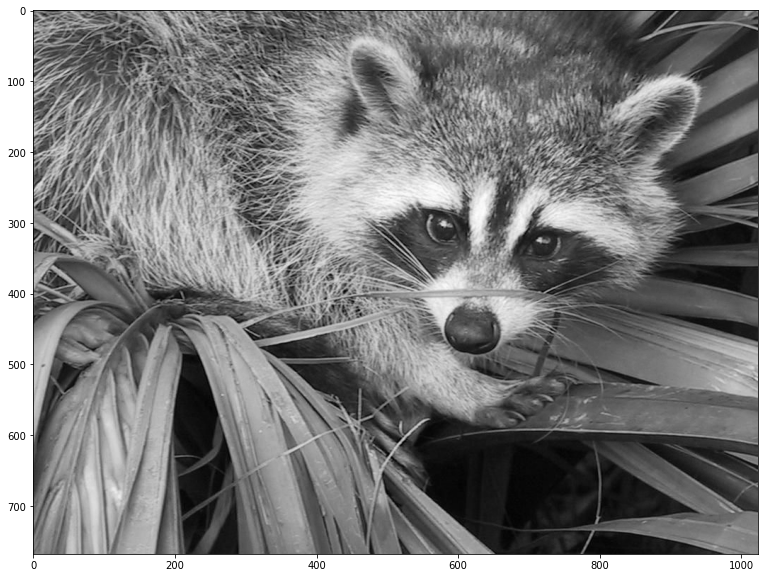

Correlation between i and p parameters
[[1.         0.99623542]
 [0.99623542 1.        ]]
Correlation between i and d parameters
[[1.         0.08452595]
 [0.08452595 1.        ]]
Correlation between i and m parameters
[[ 1.         -0.04414394]
 [-0.04414394  1.        ]]
Correlation between i and mrdn parameters
[[1.         0.02293116]
 [0.02293116 1.        ]]
Correlation between p and d parameters
[[ 1.         -0.00217103]
 [-0.00217103  1.        ]]
Correlation between p and m parameters
[[ 1.         -0.05187949]
 [-0.05187949  1.        ]]
Correlation between p and mrdn parameters
[[1.         0.02823816]
 [0.02823816 1.        ]]
Correlation between m and mrdn parameters
[[ 1.         -0.80107296]
 [-0.80107296  1.        ]]


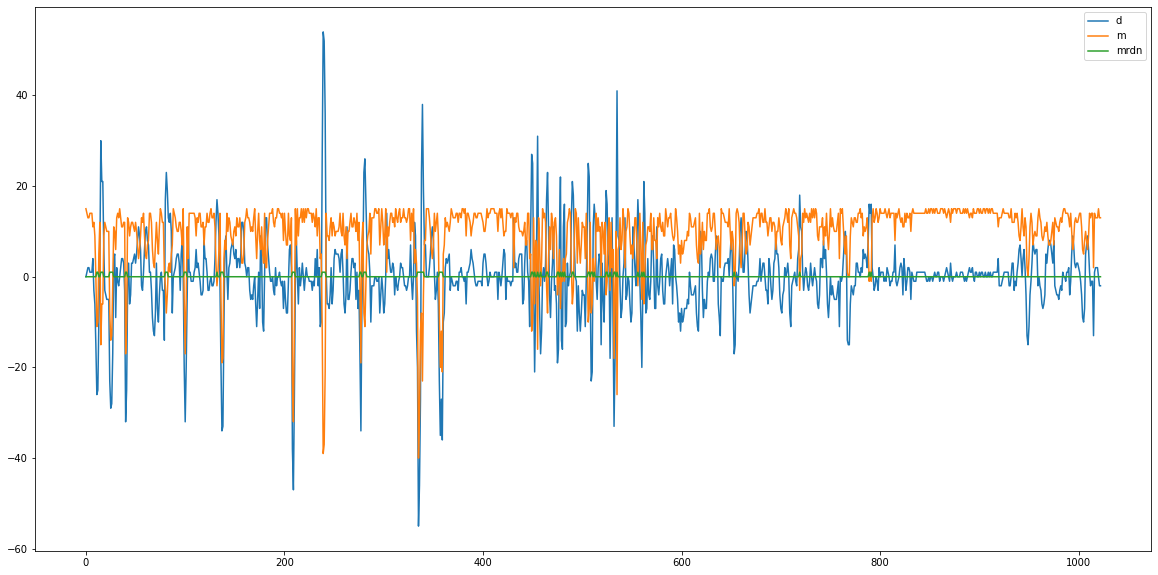

0.7039666175842285


In [41]:

render = 1
fline_PPs = 0
frecursive = 0
logging = 1  # logging of local functions variables

#---------------- Temporary code start --------------
if logging: #  log dert_
    import csv
    with open("layer0_log.csv", "w") as csvFile:
        write = csv.writer(csvFile, delimiter=",")
        parameter_names = [" ", "i=", "p=", "d=", "m=", "mrdn="]
        write.writerow(parameter_names)

start_time = time()
image = cv2.imread('raccoon.jpg', 0).astype(int)  # manual load pix-mapped image
assert image is not None, "No image in the path"

if render:
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.figure(); plt.imshow(image, cmap='gray'); plt.show()  # show the image below in gray
#---------------- Temporary code end --------------

# Main
Y, X = image.shape  # Y: frame height, X: frame width
frame = []
for y in range(init_y, min(halt_y, Y)):  # y is index of new row pixel_, we only need one row, use init_y=0, halt_y=Y for full frame
    line = line_Ps_root( image[y,:])  # line = [Pm_, Pd_]
    # frame.append(line)  # if fline_PPs: line is root CPp, else [Pm_, Pd_]

end_time = time() - start_time
print(end_time)
